Rows: 1070
   original_id        artists               track name  emotionality  \
0       102482       Emre Fel    Sevgilim Biz Ayrıldık      0.409839   
1       102649  Sertab Erener  Dandini Dandini Dastana      0.508106   
2       102799  Sertab Erener          Fış Fış Kayıkçı      0.531717   
3       102882     Sera Savaş       Anlatsam Anlatamam      0.290220   
4       102903  Ufuk Beydemir           Ay Tenli Kadın      0.261012   

  emotion_type  emotion_score  culture  
0      SADNESS       0.987372  Turkish  
1        ANGER       0.382865  Turkish  
2          JOY       0.997330  Turkish  
3      SADNESS       0.978809  Turkish  
4         LOVE       0.473822  Turkish  

Columns: ['original_id', 'artists', 'track name', 'emotionality', 'emotion_type', 'emotion_score', 'culture']

===== CULTURE COUNTS =====
culture
Turkish    901
Balkan     169
Name: count, dtype: int64

===== SUMMARY STATISTICS =====
         count      mean       std      min       25%       50%       75%  

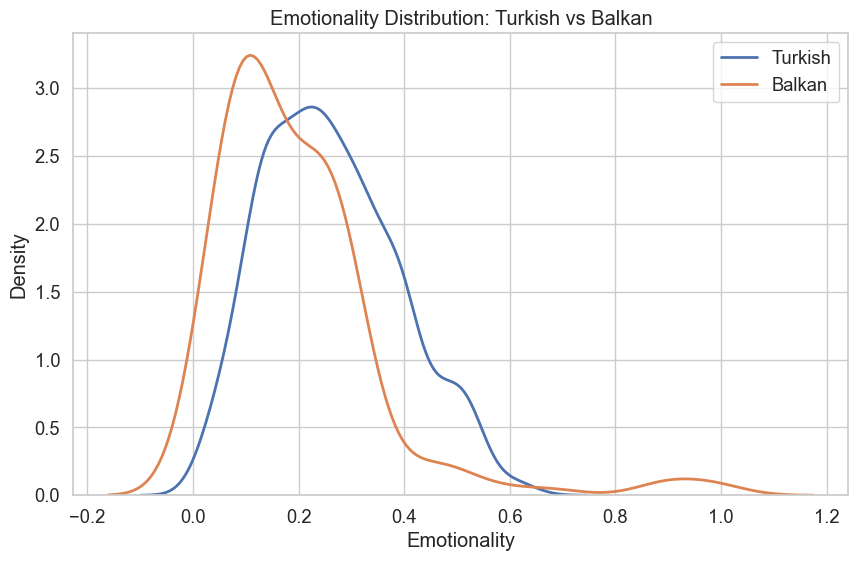

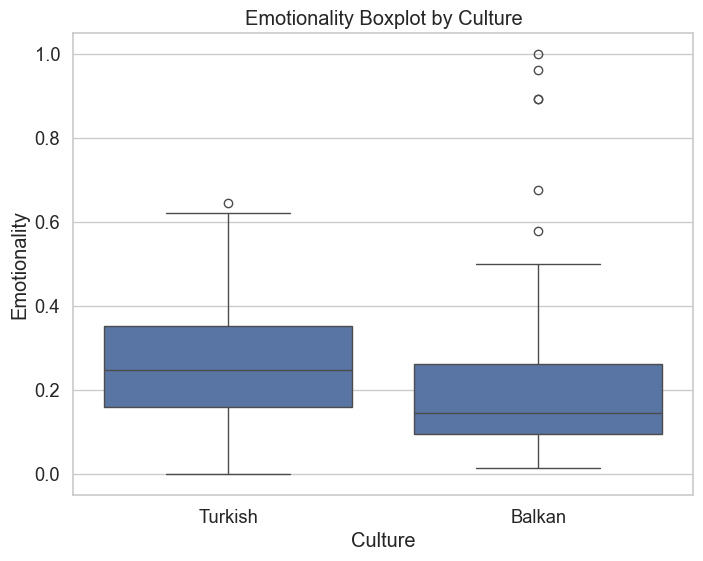

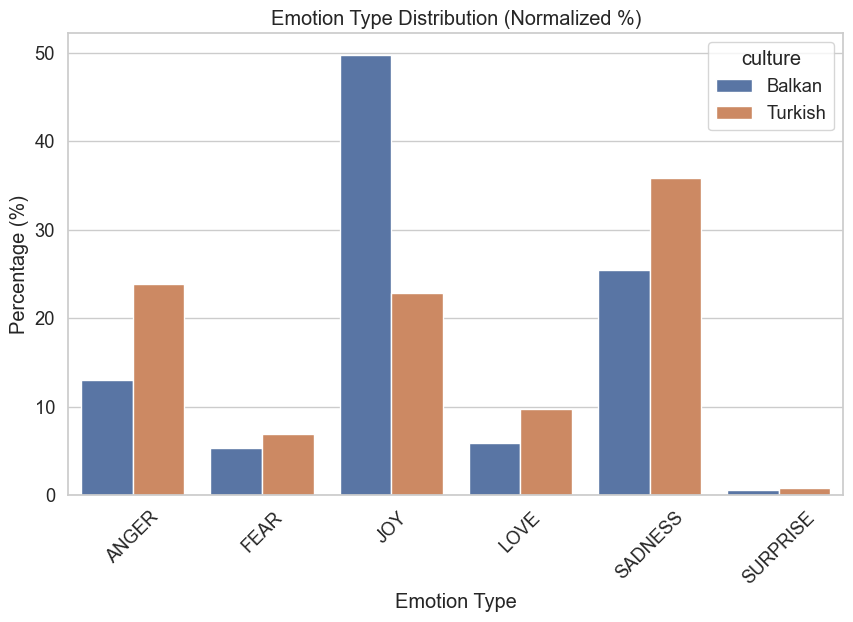

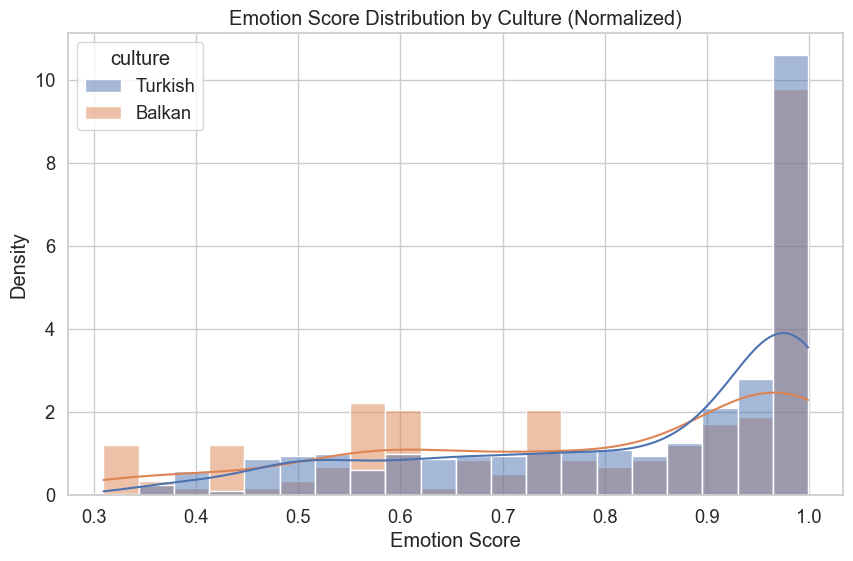

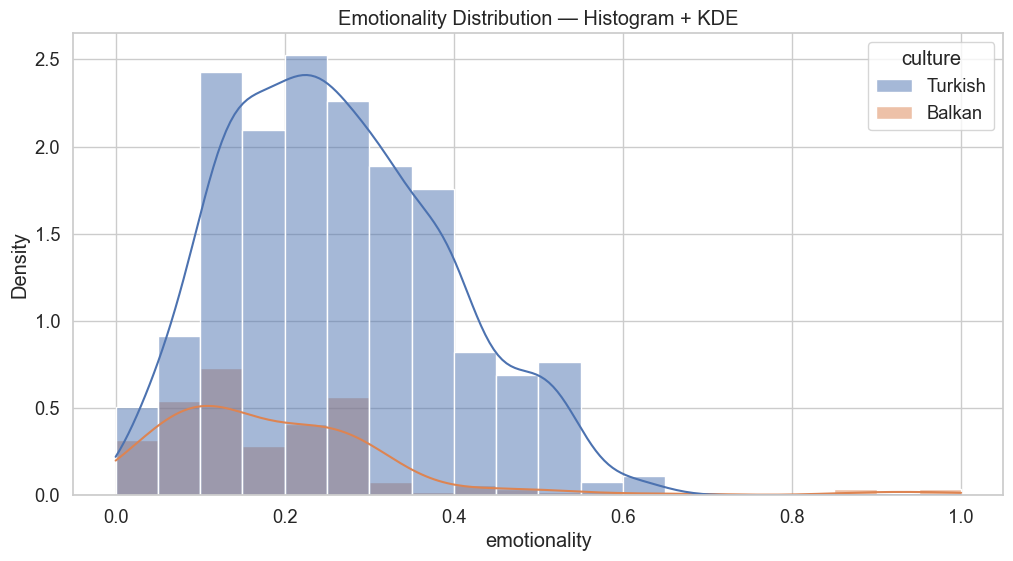

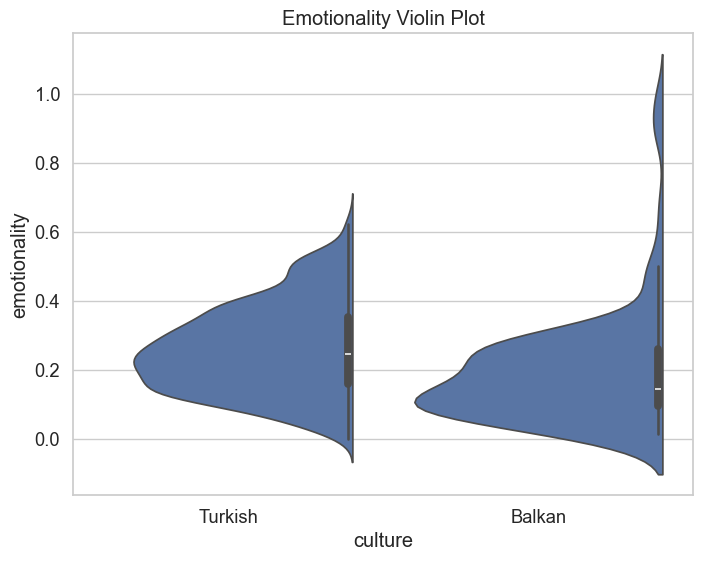

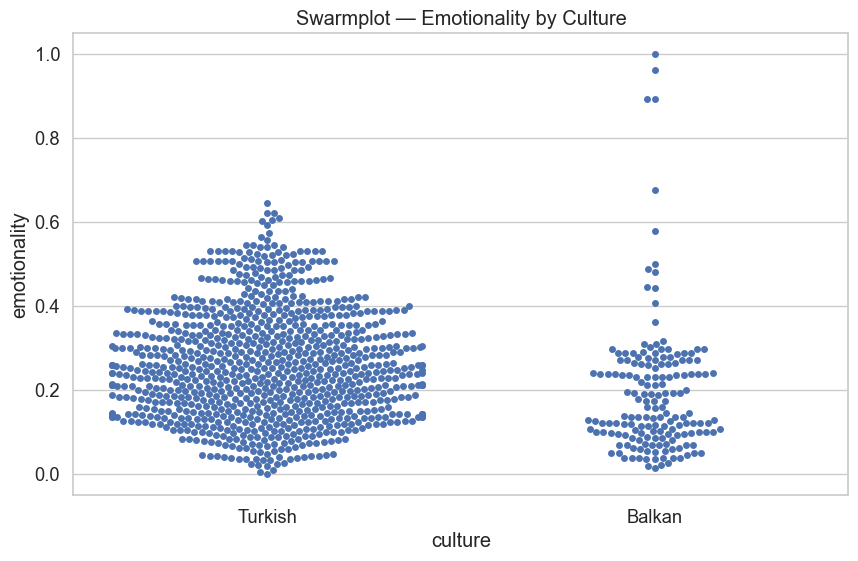

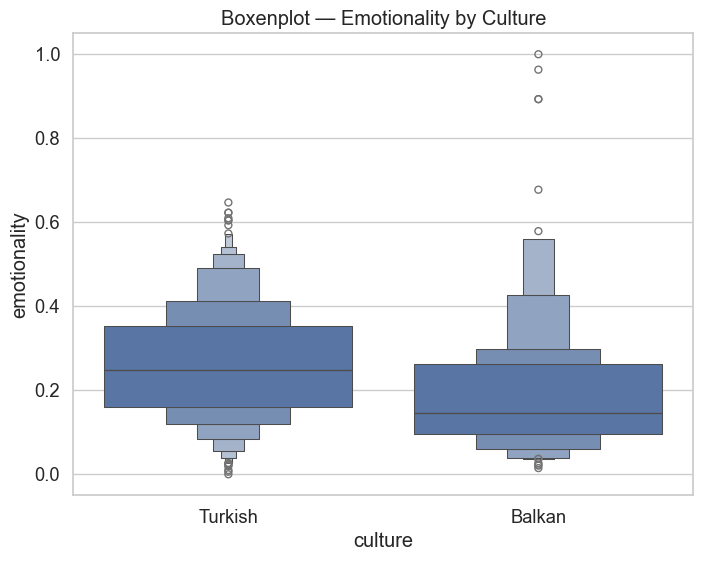

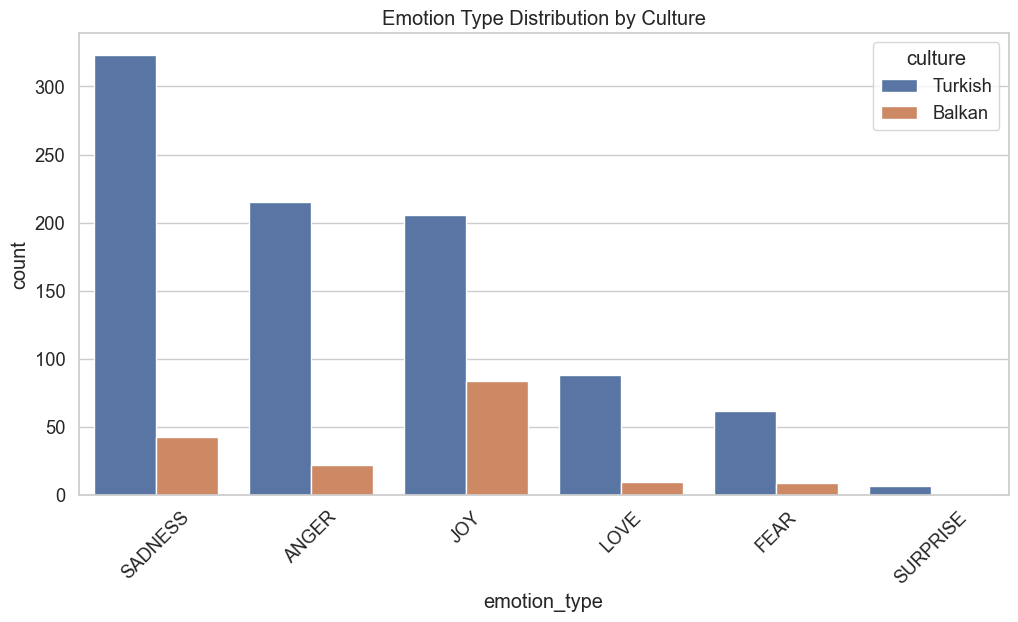

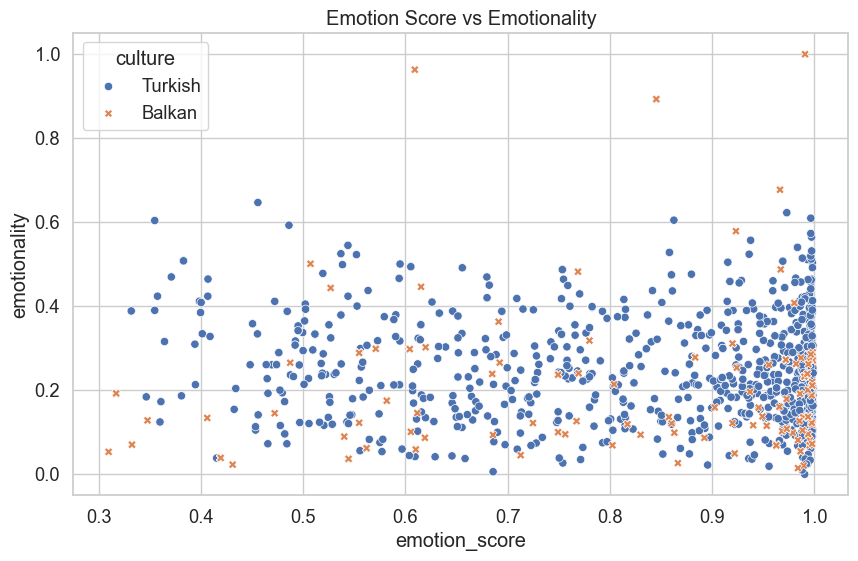

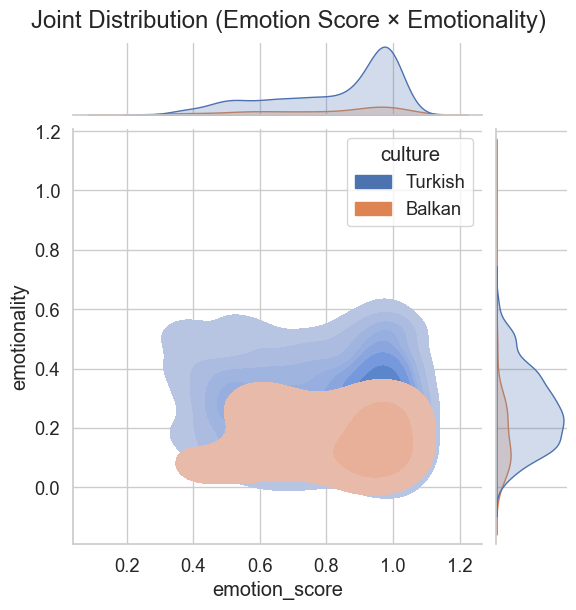

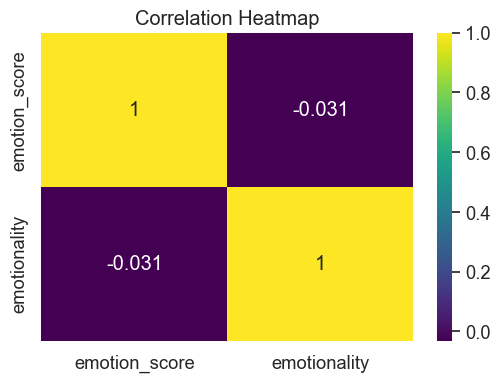

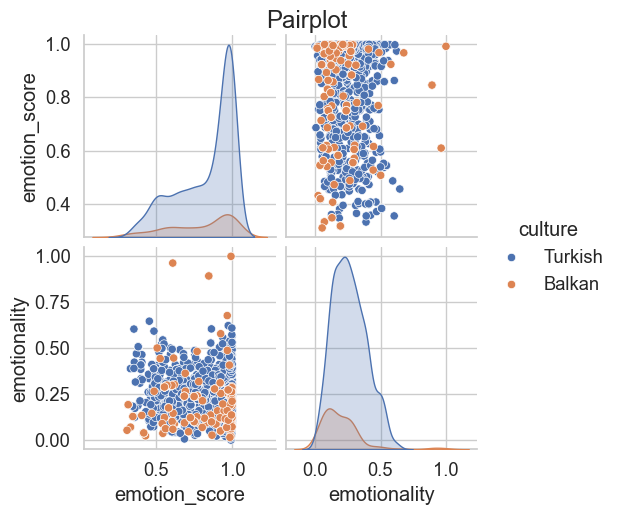

C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)


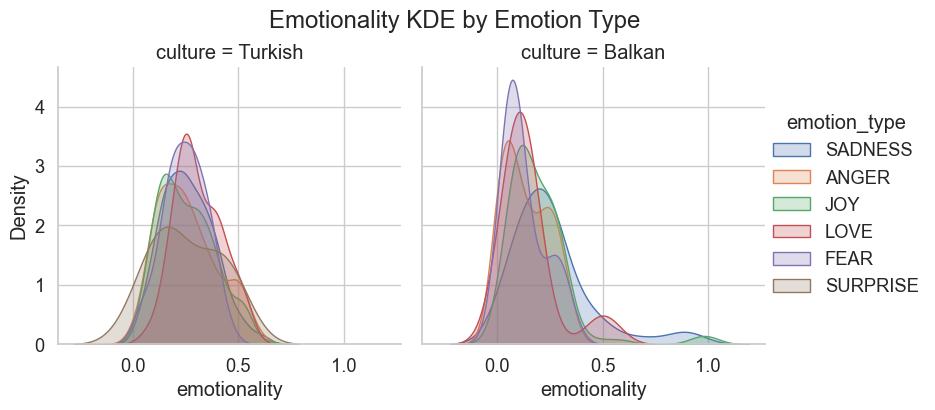

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15320\4267069379.py:305: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df, x="culture", y="emotionality", ci=95)


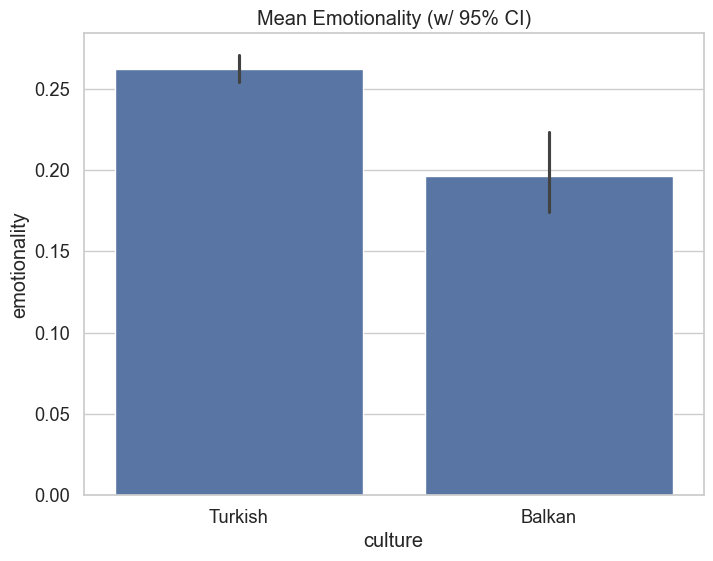


===== ANALYSIS COMPLETE =====


In [1]:
# ============================================================
#   TURKISH vs BALKAN SONG EMOTIONALITY — ADVANCED ANALYSIS
# ============================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import (
    ttest_ind, 
    shapiro, 
    mannwhitneyu, 
    levene,
    pearsonr,
    f_oneway
)

from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set(style="whitegrid", font_scale=1.2)

# -----------------------------------------
# 1. LOAD DATA
# -----------------------------------------

df = pd.read_csv("FINAL_PROJECT_DATASET.csv")
df["culture"] = df["culture"].astype(str).str.strip()

print("Rows:", len(df))
print(df.head())
print("\nColumns:", df.columns.tolist())

# -------------------------------------------------------------
# 2. BASIC OVERVIEW
# -------------------------------------------------------------

print("\n===== CULTURE COUNTS =====")
print(df["culture"].value_counts())

print("\n===== SUMMARY STATISTICS =====")
print(df.groupby("culture")["emotionality"].describe())

print("\n===== EMOTION TYPE TABLE =====")
emotion_table = pd.crosstab(df["emotion_type"], df["culture"])
print(emotion_table)

# -------------------------------------------------------------
# 3. NORMALITY CHECKS
# -------------------------------------------------------------

print("\n===== NORMALITY (Shapiro–Wilk) =====")
for culture in ["Turkish", "Balkan"]:
    vals = df[df["culture"] == culture]["emotionality"]
    stat, p = shapiro(vals)
    print(f"{culture}: p = {p:.4f}")

# -------------------------------------------------------------
# 4. VARIANCE HOMOGENEITY
# -------------------------------------------------------------

print("\n===== HOMOGENEITY OF VARIANCE (Levene) =====")
lev_stat, lev_p = levene(
    df[df["culture"]=="Turkish"]["emotionality"],
    df[df["culture"]=="Balkan"]["emotionality"]
)
print("Levene p =", lev_p)

# -------------------------------------------------------------
# 5. T-TEST + EFFECT SIZE
# -------------------------------------------------------------

t_vals = df[df["culture"]=="Turkish"]["emotionality"]
b_vals = df[df["culture"]=="Balkan"]["emotionality"]

t_stat, p_val = ttest_ind(t_vals, b_vals, equal_var=False)

def cohens_d(a, b):
    return (a.mean() - b.mean()) / np.sqrt(((a.var() + b.var()) / 2))

d = cohens_d(t_vals, b_vals)

print("\n===== T-TEST RESULTS =====")
print("t =", t_stat)
print("p =", p_val)
print("Cohen's d =", d)

# -------------------------------------------------------------
# 6. NON-PARAMETRIC ALTERNATIVE
# -------------------------------------------------------------

mw_stat, mw_p = mannwhitneyu(t_vals, b_vals)

print("\n===== MANN-WHITNEY U (non-parametric) =====")
print("MW p =", mw_p)

# -------------------------------------------------------------
# 7. BOOTSTRAP CONFIDENCE INTERVALS
# -------------------------------------------------------------

def bootstrap_mean_ci(data, n_bootstrap=5000, alpha=0.05):
    boot_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        boot_means.append(sample.mean())
    lower = np.percentile(boot_means, 100*alpha/2)
    upper = np.percentile(boot_means, 100*(1-alpha/2))
    return lower, upper

ci_turkish = bootstrap_mean_ci(t_vals)
ci_balkan = bootstrap_mean_ci(b_vals)

print("\n===== BOOTSTRAP CONFIDENCE INTERVALS (means) =====")
print("Turkish emotionality CI:", ci_turkish)
print("Balkan emotionality CI:", ci_balkan)

# -------------------------------------------------------------
# 8. REGRESSION: Predict Emotionality
# -------------------------------------------------------------

print("\n===== LINEAR REGRESSION (ALL DATA) =====")

formula = "emotionality ~ culture + emotion_score"
model = smf.ols(formula, data=df).fit()
print(model.summary())

# Culture-specific
for culture in ["Turkish", "Balkan"]:
    print(f"\n===== REGRESSION FOR {culture.upper()} =====")
    sub = df[df["culture"] == culture]
    model = smf.ols("emotionality ~ emotion_score", data=sub).fit()
    print(model.summary())

# -------------------------------------------------------------
# 9. ANOVA (culture → emotionality)
# -------------------------------------------------------------

groups = [
    df[df["culture"]=="Turkish"]["emotionality"],
    df[df["culture"]=="Balkan"]["emotionality"]
]

anova_stat, anova_p = f_oneway(*groups)

print("\n===== ANOVA (culture → emotionality) =====")
print("p =", anova_p)

# -------------------------------------------------------------
# 10. Tukey HSD
# -------------------------------------------------------------

tukey_data = df[["emotion_type", "emotionality"]].dropna()

tukey = pairwise_tukeyhsd(
    endog=tukey_data["emotionality"],
    groups=tukey_data["emotion_type"],
    alpha=0.05
)

print("\n===== TUKEY HSD RESULTS =====")
print(tukey)

# ============================================================
#   ADVANCED VISUALIZATIONS
# ============================================================

# 1. EMOTIONALITY DISTRIBUTION (KDE PLOTS)

plt.figure(figsize=(10,6))
sns.kdeplot(df[df["culture"]=="Turkish"]["emotionality"], label="Turkish", linewidth=2)
sns.kdeplot(df[df["culture"]=="Balkan"]["emotionality"], label="Balkan", linewidth=2)
plt.title("Emotionality Distribution: Turkish vs Balkan")
plt.xlabel("Emotionality")
plt.ylabel("Density")
plt.legend()
plt.show()

# 2. EMOTIONALITY BOXPLOT

plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="culture", y="emotionality")
plt.title("Emotionality Boxplot by Culture")
plt.xlabel("Culture")
plt.ylabel("Emotionality")
plt.show()


# 3. NORMALIZED EMOTION TYPE DISTRIBUTION (PERCENTAGES)

# Count emotion types per culture
emotion_counts = df.groupby(["culture", "emotion_type"]).size().reset_index(name="count")

# Normalize counts to percentages within each culture
emotion_counts["percentage"] = (
    emotion_counts["count"] / emotion_counts.groupby("culture")["count"].transform("sum") * 100
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=emotion_counts,
    x="emotion_type",
    y="percentage",
    hue="culture"
)

plt.title("Emotion Type Distribution (Normalized %)")
plt.xlabel("Emotion Type")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.show()


# 4. EMOTION SCORE DISTRIBUTION (HISTOGRAM)

plt.figure(figsize=(10,6))
sns.histplot(
    data=df,
    x="emotion_score",
    hue="culture",
    kde=True,
    stat="density",     # <--- IMPORTANT: normalize
    common_norm=False,  # each culture normalized separately
    bins=20
)

plt.title("Emotion Score Distribution by Culture (Normalized)")
plt.xlabel("Emotion Score")
plt.ylabel("Density")
plt.show()

# 5. Histogram + KDE
plt.figure(figsize=(12,6))
sns.histplot(data=df, x="emotionality", hue="culture", kde=True, stat="density", bins=20)
plt.title("Emotionality Distribution — Histogram + KDE")
plt.show()

# 6. Violin Plot
plt.figure(figsize=(8,6))
sns.violinplot(data=df, x="culture", y="emotionality", split=True)
plt.title("Emotionality Violin Plot")
plt.show()

# 7. Swarmplot
plt.figure(figsize=(10,6))
sns.swarmplot(data=df, x="culture", y="emotionality", size=5)
plt.title("Swarmplot — Emotionality by Culture")
plt.show()

# 8. Boxenplot
plt.figure(figsize=(8,6))
sns.boxenplot(data=df, x="culture", y="emotionality")
plt.title("Boxenplot — Emotionality by Culture")
plt.show()

# 9. Emotion Type Distribution by Culture
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="emotion_type", hue="culture")
plt.title("Emotion Type Distribution by Culture")
plt.xticks(rotation=45)
plt.show()

# 10. Scatter: emotion_score vs emotionality
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df, x="emotion_score", y="emotionality", hue="culture", style="culture"
)
plt.title("Emotion Score vs Emotionality")
plt.show()

# 11. Jointplot
sns.jointplot(
    data=df,
    x="emotion_score",
    y="emotionality",
    hue="culture",
    kind="kde",
    fill=True
)
plt.suptitle("Joint Distribution (Emotion Score × Emotionality)", y=1.02)
plt.show()

# 12. Correlation Heatmap
plt.figure(figsize=(6,4))
corr = df[["emotion_score", "emotionality"]].corr()
sns.heatmap(corr, annot=True, cmap="viridis")
plt.title("Correlation Heatmap")
plt.show()

# 13. Pairplot
sns.pairplot(df, vars=["emotion_score", "emotionality"], hue="culture")
plt.suptitle("Pairplot", y=1.02)
plt.show()

# 14. FacetGrid: emotion_type → emotionality
g = sns.FacetGrid(df, col="culture", hue="emotion_type", col_wrap=2, height=4)
g.map(sns.kdeplot, "emotionality", fill=True)
g.add_legend()
plt.suptitle("Emotionality KDE by Emotion Type", y=1.03)
plt.show()

# 15. Barplot with Confidence Intervals
plt.figure(figsize=(8,6))
sns.barplot(data=df, x="culture", y="emotionality", ci=95)
plt.title("Mean Emotionality (w/ 95% CI)")
plt.show()

print("\n===== ANALYSIS COMPLETE =====")
